In [3]:
!pip install tensorflow

In [4]:
!pip install keras-tuner

In [5]:
!pip install xgboost

C:\Users\Alketa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Alketa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Model,MAE,RMSE,MAPE_%,R2,Accuracy_%
0,Naive D1 (y(t-24)),70.09,96.11,12.80,0.7830,87.20
1,Naive W1 (y(t-168)),106.24,139.59,19.78,0.5421,80.22


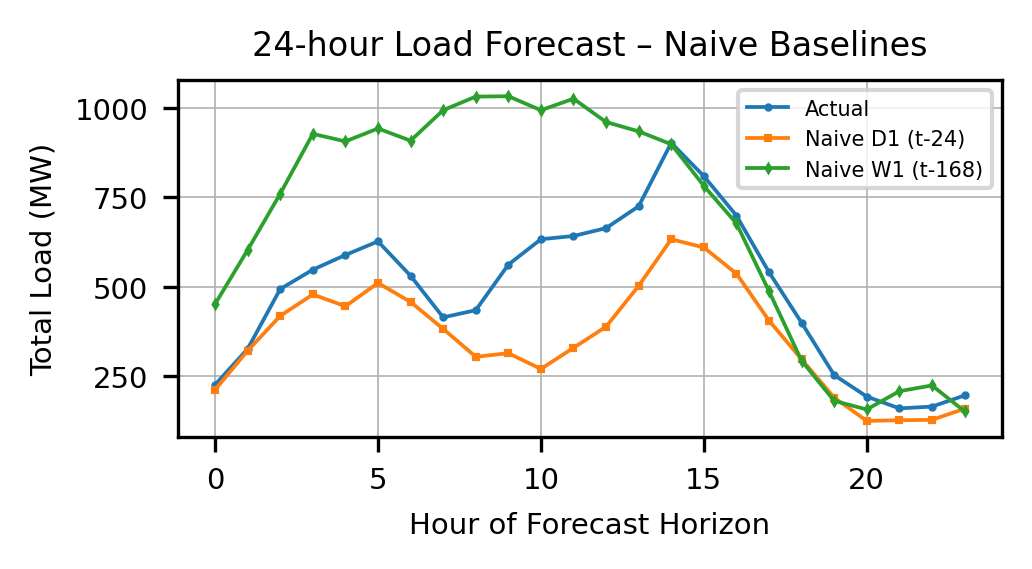

In [11]:
# ======================= Setup (Baselines only) =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

np.random.seed(42)

# =================== 1) Load & clean =================
df = pd.read_csv("ost_data_clean.csv", sep=';', engine='python')

df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
df['Ora'] = (
    df['Ora']
    .astype(str)
    .str.extract(r'(\d+)', expand=False)
    .astype(int)
    .astype(str)
    .str.zfill(2)
)

df['Datetime'] = pd.to_datetime(
    df['Data'].dt.strftime('%Y-%m-%d') + ' ' + df['Ora'],
    format='%Y-%m-%d %H',
    errors='coerce'
)
df.set_index('Datetime', inplace=True)
df.dropna(inplace=True)

# Total cross-border exchange if missing
if 'Shkembimi fizik nderkufitar' not in df.columns:
    for c in ['Shkembimi fizik nderkufitar AL-ME',
              'Shkembimi fizik nderkufitar AL-KS',
              'Shkembimi fizik nderkufitar AL-GR']:
        if c not in df.columns:
            df[c] = 0.0
    df['Shkembimi fizik nderkufitar'] = (
        df['Shkembimi fizik nderkufitar AL-ME'] +
        df['Shkembimi fizik nderkufitar AL-KS'] +
        df['Shkembimi fizik nderkufitar AL-GR']
    )

base_cols = [
    'Ngarkesa Totale',
    'Prodhimi Total',
    'Shkembimi fizik nderkufitar',
    'Shkembimi fizik nderkufitar AL-ME',
    'Shkembimi fizik nderkufitar AL-KS',
    'Shkembimi fizik nderkufitar AL-GR'
]
df = df[base_cols].copy()

# =============== 2) Time features & lags =============
df['Hour']      = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month']     = df.index.month
df['Weekend']   = (df.index.dayofweek >= 5).astype(int)

df['lag_1']   = df['Ngarkesa Totale'].shift(1)
df['lag_24']  = df['Ngarkesa Totale'].shift(24)
df['lag_48']  = df['Ngarkesa Totale'].shift(48)
df['lag_168'] = df['Ngarkesa Totale'].shift(168)

df['roll_mean_24'] = df['Ngarkesa Totale'].rolling(24).mean()
df['roll_std_24']  = df['Ngarkesa Totale'].rolling(24).std()
df['roll_max_24']  = df['Ngarkesa Totale'].rolling(24).max()
df['roll_min_24']  = df['Ngarkesa Totale'].rolling(24).min()

df['Total_Exchange'] = (
    df['Shkembimi fizik nderkufitar'] +
    df['Shkembimi fizik nderkufitar AL-ME'] +
    df['Shkembimi fizik nderkufitar AL-KS'] +
    df['Shkembimi fizik nderkufitar AL-GR']
)
df['Delta_Exchange'] = df['Total_Exchange'].diff()

def add_fourier(df_in, tag, period, K=3):
    t = np.arange(len(df_in), dtype=float)
    for k in range(1, K+1):
        df_in[f'{tag}_sin_{period}_{k}'] = np.sin(2*np.pi*k*t/period)
        df_in[f'{tag}_cos_{period}_{k}'] = np.cos(2*np.pi*k*t/period)
    return df_in

df = add_fourier(df, 'fourier_daily', 24,  K=3)
df = add_fourier(df, 'fourier_weekly', 168, K=3)

df.dropna(inplace=True)

# ================= 3) Make 24→24 sequences (ONLY for y_true + times) =================
target_col = 'Ngarkesa Totale'
n_input  = 24
n_output = 24

def make_y_times(df_frame, n_in=24, n_out=24, target='Ngarkesa Totale'):
    """Return y_true (N, n_out) and times (N, n_out) from the real (unscaled) df."""
    y, times = [], []
    idx = df_frame.index
    for i in range(n_in, len(df_frame) - n_out + 1):
        y.append(df_frame.iloc[i:i+n_out][target].values)
        times.append(idx[i:i+n_out].values)
    return np.array(y), np.array(times)

# Time split (70/10/20) - same logic
n_total     = len(df)
i_train_end = int(n_total * 0.70)
i_val_end   = int(n_total * 0.80)

df_train = df.iloc[:i_train_end].copy()
df_val   = df.iloc[i_train_end:i_val_end].copy()
df_test  = df.iloc[i_val_end:].copy()

y_te_true, times_test = make_y_times(df_test, n_input, n_output, target_col)

# ================= 4) Baselines: Naive D-1 and W-1 =================
def make_naive_baseline(times_2d, df_full, lag_hours, target='Ngarkesa Totale'):
    """
    y_hat(t) = y(t - lag_hours)
    times_2d should be (N, 24) timestamps (e.g., times_test).
    """
    N, H = times_2d.shape
    y_hat = np.zeros((N, H), dtype=float)

    for i in range(N):
        for h in range(H):
            t = times_2d[i, h]
            t_lag = t - pd.Timedelta(hours=lag_hours)
            try:
                y_hat[i, h] = df_full.loc[t_lag, target]
            except KeyError:
                prev_times = df_full.index[df_full.index <= t_lag]
                if len(prev_times) > 0:
                    y_hat[i, h] = df_full.loc[prev_times[-1], target]
                else:
                    y_hat[i, h] = df_full[target].mean()
    return y_hat

y_te_naive_D1 = make_naive_baseline(times_test, df, lag_hours=24,  target=target_col)
y_te_naive_W1 = make_naive_baseline(times_test, df, lag_hours=168, target=target_col)

# ================= 5) Metrics -> Table =================
def eval_metrics_dict(y_true_2d, y_pred_2d):
    yt = y_true_2d.reshape(-1)
    yp = y_pred_2d.reshape(-1)

    mae  = mean_absolute_error(yt, yp)
    rmse = mean_squared_error(yt, yp, squared=False)

    eps = 1e-6
    yt_safe = np.where(yt == 0, eps, yt)
    mape = mean_absolute_percentage_error(yt_safe, yp) * 100

    r2  = r2_score(yt, yp)
    acc = 100 - mape
    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape, "R2": r2, "Accuracy_%": acc}

rows = []
rows.append({"Model": "Naive D1 (y(t-24))",  **eval_metrics_dict(y_te_true, y_te_naive_D1)})
rows.append({"Model": "Naive W1 (y(t-168))", **eval_metrics_dict(y_te_true, y_te_naive_W1)})

metrics_df = pd.DataFrame(rows)
# pak formatim i bukur
display(metrics_df.style.format({"MAE":"{:.2f}", "RMSE":"{:.2f}", "MAPE_%":"{:.2f}", "R2":"{:.4f}", "Accuracy_%":"{:.2f}"}))

# ================= 6) 24-hour plot (sample) =================
sample_idx = 0
hours = np.arange(24)

plt.figure(figsize=(3.54, 2), dpi=300)
plt.plot(hours, y_te_true[sample_idx],     marker='o', markersize=1, linewidth=0.9, label='Actual')
plt.plot(hours, y_te_naive_D1[sample_idx], marker='s', markersize=1, linewidth=0.9, label='Naive D1 (t-24)')
plt.plot(hours, y_te_naive_W1[sample_idx], marker='d', markersize=1, linewidth=0.9, label='Naive W1 (t-168)')

plt.title('24-hour Load Forecast – Naive Baselines', fontsize=8)
plt.xlabel('Hour of Forecast Horizon', fontsize=7)
plt.ylabel('Total Load (MW)', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(True, linewidth=0.4)
plt.legend(fontsize=5)
plt.tight_layout()
plt.savefig(f"forecast_naive_D1_W1_sample{sample_idx}.png", dpi=300, bbox_inches='tight')
plt.show()


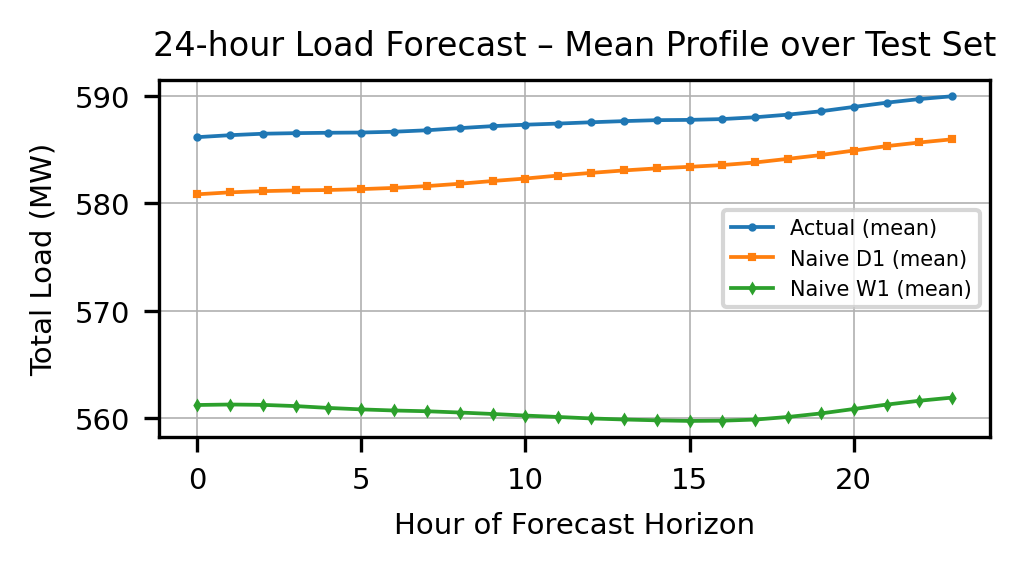

In [12]:
# ================= 7) Representative plot: mean over ALL test samples =================
# Mesatarja e profilit 24-orësh në gjithë testin (N test samples)

mean_true = y_te_true.mean(axis=0)
mean_D1   = y_te_naive_D1.mean(axis=0)
mean_W1   = y_te_naive_W1.mean(axis=0)

plt.figure(figsize=(3.5, 2), dpi=300)
plt.plot(hours, mean_true, marker='o', markersize=1, linewidth=0.9, label='Actual (mean)')
plt.plot(hours, mean_D1,   marker='s', markersize=1, linewidth=0.9, label='Naive D1 (mean)')
plt.plot(hours, mean_W1,   marker='d', markersize=1, linewidth=0.9, label='Naive W1 (mean)')

plt.title('24-hour Load Forecast – Mean Profile over Test Set', fontsize=8)
plt.xlabel('Hour of Forecast Horizon', fontsize=7)
plt.ylabel('Total Load (MW)', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(True, linewidth=0.4)
plt.legend(fontsize=5)
plt.tight_layout()
plt.savefig("forecast_naive_D1_W1_meanprofile.png", dpi=300, bbox_inches='tight')
plt.show()
